In [1]:
import pandas as pd
import numpy as np
from bertopic import BERTopic

/opt/anaconda3/envs/bert_pls/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("mental_health.csv")

In [3]:
df.head()

,text,label
0,dear american teens question dutch person hear...,0
1,nothing look forward lifei dont many reasons k...,1
2,music recommendations im looking expand playli...,0
3,im done trying feel betterthe reason im still ...,1
4,worried year old girl subject domestic physic...,1


In [4]:
df.info

<bound method DataFrame.info of                                                     text  label
0      dear american teens question dutch person hear...      0
1      nothing look forward lifei dont many reasons k...      1
2      music recommendations im looking expand playli...      0
3      im done trying feel betterthe reason im still ...      1
4      worried  year old girl subject domestic physic...      1
...                                                  ...    ...
27972  posting everyday people stop caring  religion ...      0
27973  okay definetly need hear guys opinion ive pret...      0
27974  cant get dog think ill kill myselfthe last thi...      1
27975  whats point princess bridei really think like ...      1
27976  got nudes person might might know snapchat do ...      0

[27977 rows x 2 columns]>

In [5]:
df['label'].value_counts()

label
0    14139
1    13838
Name: count, dtype: int64

In [6]:
data = df[['text']]
data.head()

,text
0,dear american teens question dutch person hear...
1,nothing look forward lifei dont many reasons k...
2,music recommendations im looking expand playli...
3,im done trying feel betterthe reason im still ...
4,worried year old girl subject domestic physic...


## Data Pre-processing

In [7]:
import re
import spacy
import stopwords
import nltk

nlp_model = spacy.load("en_core_web_sm") # load model
stop_words_spacy = spacy.lang.en.stop_words.STOP_WORDS
#stop_words_nltk = stopwords.words('english')
custom_stopwords = ['just', 's', 'br', 'wa', 'don', "ve", "ha", "doe", "m", "ll", "didn", "doesn", "wan", "na"]
stop_words_spacy.update(custom_stopwords)


processed_text = []
def spacy_preprocessing(text, stop_words = None, lemmatize = False):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Subs non-alphabetic characters to spaces
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[\W_]+', ' ', text)  # Remove non-word characters (punctuation and symbols)
    text = re.sub("\s+", ' ', text)  # Subs double spaces and more with a single space
    text = text.strip()  # Trims whitespaces at the ends
    text = re.sub(r'\b\w\b', '', text)  # Remove single characters
   
    if lemmatize == True:
        doc = nlp_model(text)
        text = [token.lemma_.strip() for token in doc if not token.is_stop and token.lemma_]
        text = ' '.join(text)
    else:
        text = ' '.join(text)
        
    if stop_words is not None:
        text = [token for token in text.split() 
                if token not in stop_words]      
        text = ' '.join(text)
    else:
        text = ' '.join(text)
    return text


In [8]:
df['processed_text'] = df['text'].apply(lambda x: spacy_preprocessing(x, stop_words_spacy, lemmatize = True))

In [9]:
df.sample(20)

,text,label,processed_text
11756,months still cannot get together even want get...,1,month want bed anymore tired want sleep think ...
8062,people hoping catch coronavirus diebecause ive...,1,people hope catch coronavirus diebecause read ...
26505,first saw movie theater france year ago came w...,0,movie theater france year ago came little fanf...
4025,hell wrong meso basically scrolling subreddit ...,1,hell wrong meso basically scroll subreddit day...
603,ive done nothing contributeim taking space usi...,1,contributeim space food water people time aspi...
11236,ready throw towelno one willing help care lov...,1,ready throw towelno willing help care love stu...
19469,whats good dudes first post sub wanted say hi,0,good dude post sub want hi
9410,everything life ruined lost job friends close ...,1,life ruin lost job friend close lose relations...
12378,messed bad today final term maths exam stupid ...,0,mess bad today final term math exam stupid ass...
6685,someones flirting gf getting weird one friend ...,0,flirt gf weird friend group right friday night...


In [10]:
df.shape

(27977, 3)

In [11]:
# Dropping null values
df = df.dropna(subset=['processed_text'])


In [12]:
# Dropping duplicates
df = df.drop_duplicates(subset=['processed_text'])


In [13]:
df.shape

(27965, 3)

## Detecting Only English Reviews

In [14]:
import pandas as pd
from langdetect import detect

# İngilizce olan reviewları filtreleme
def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

df['is_english'] = df['processed_text'].apply(is_english)
english_reviews_df = df[df['is_english'] == True]

english_reviews_df.head()


,text,label,processed_text,is_english
0,dear american teens question dutch person hear...,0,dear american teen question dutch person hear ...,True
1,nothing look forward lifei dont many reasons k...,1,look forward lifei reason feel like day want hang,True
2,music recommendations im looking expand playli...,0,music recommendation look expand playlist usua...,True
3,im done trying feel betterthe reason im still ...,1,try feel betterthe reason alive know mum devas...,True
4,worried year old girl subject domestic physic...,1,worry year old girl subject domestic physicalm...,True


In [15]:
df['is_english'].value_counts()

is_english
True     25739
False     2226
Name: count, dtype: int64

In [16]:
# Dropping non-English reviews

df = df[df['is_english'] == True].drop(columns=['is_english'])

In [17]:
df.to_csv("mental_cleaned.csv")

## Word Cloud of Processed Text

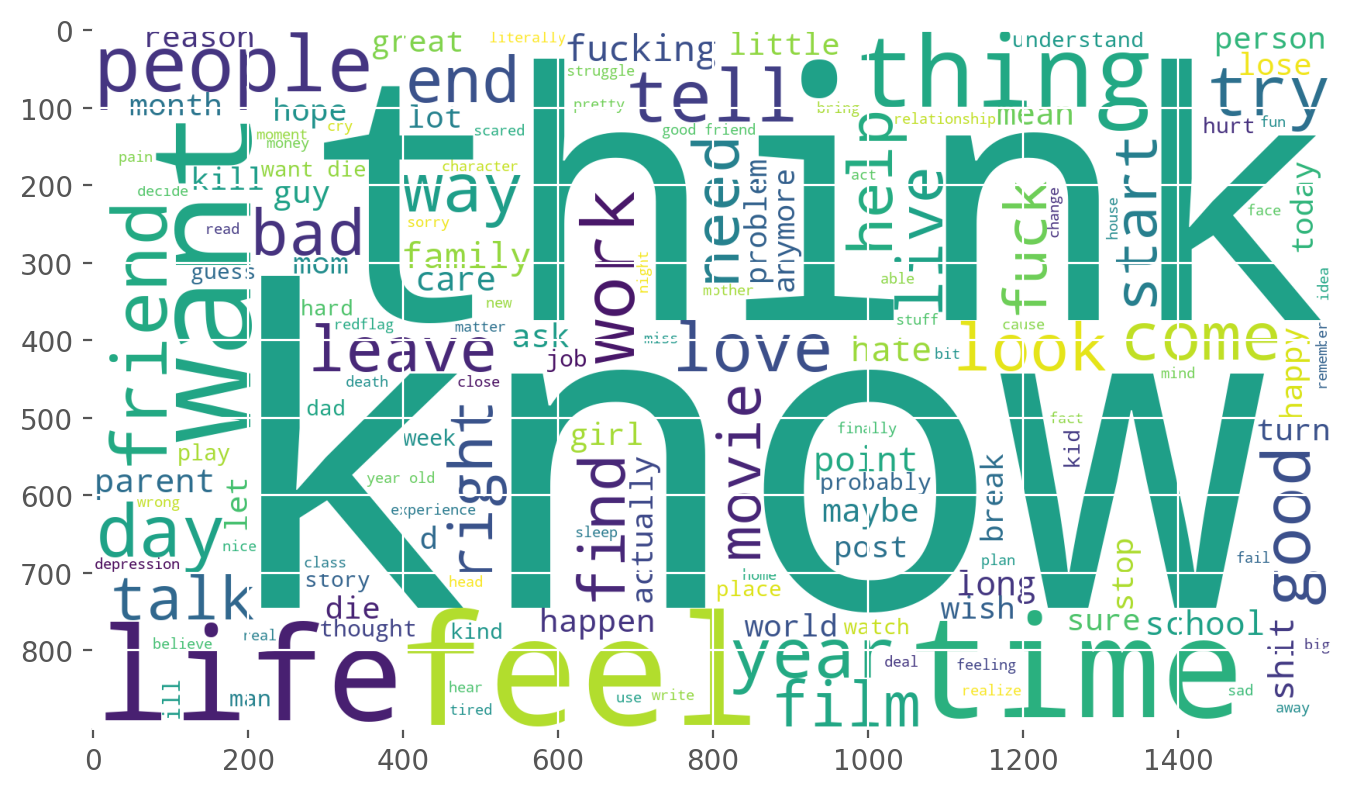

In [18]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

plt.style.use('ggplot')

full_join = ' '.join(df["processed_text"].astype(str)) 
full_join_list = full_join.split(' ')

word_cloud = WordCloud(width=1600,height=900,
                       background_color='white',
                       max_words=150).generate(full_join)

%config InlineBackend.figure_format="retina"
plt.figure(figsize=[8,8])
plt.imshow(word_cloud)
plt.savefig('Word cloud.png')
plt.show()

## Token Frequency

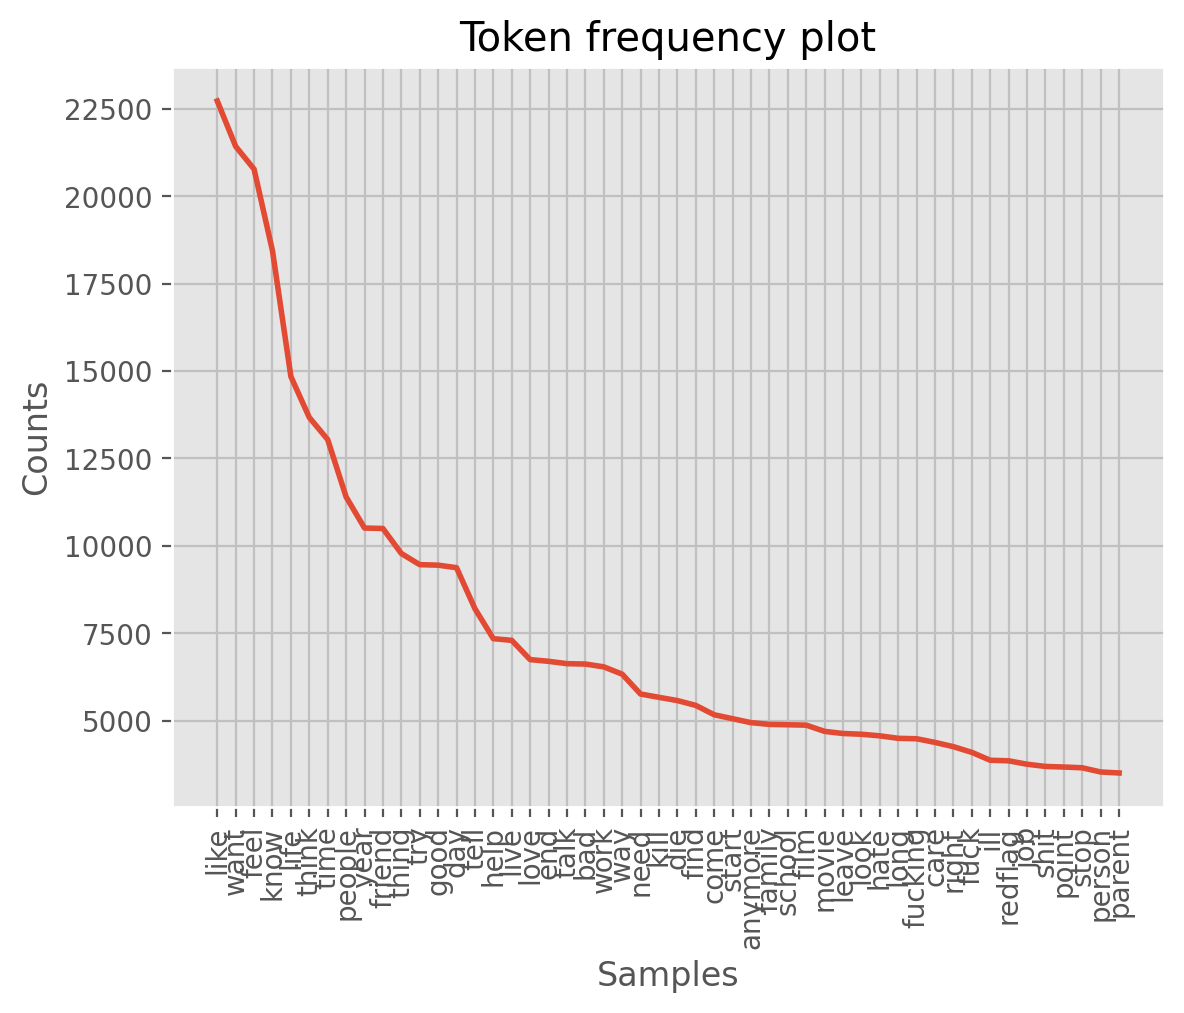

<Axes: title={'center': 'Token frequency plot'}, xlabel='Samples', ylabel='Counts'>

In [19]:
from nltk.probability import FreqDist
full_join_list = full_join.split()
freqdist = FreqDist(full_join_list)
freqdist.plot(50, title = 'Token frequency plot')

## Reading Processed Data

In [20]:
df = pd.read_csv("mental_cleaned.csv")

In [21]:
df.shape

(25739, 4)

In [22]:
df['processed_text'] = df['processed_text'].astype(str)

data = df[['processed_text']]
data.head()

,processed_text
0,dear american teen question dutch person hear ...
1,look forward lifei reason feel like day want hang
2,music recommendation look expand playlist usua...
3,try feel betterthe reason alive know mum devas...
4,worry year old girl subject domestic physicalm...


In [23]:
df

,Unnamed: 0,text,label,processed_text
0,0,dear american teens question dutch person hear...,0,dear american teen question dutch person hear ...
1,1,nothing look forward lifei dont many reasons k...,1,look forward lifei reason feel like day want hang
2,2,music recommendations im looking expand playli...,0,music recommendation look expand playlist usua...
3,3,im done trying feel betterthe reason im still ...,1,try feel betterthe reason alive know mum devas...
4,4,worried year old girl subject domestic physic...,1,worry year old girl subject domestic physicalm...
...,...,...,...,...
25734,27972,posting everyday people stop caring religion ...,0,post everyday people stop care religion matter...
25735,27973,okay definetly need hear guys opinion ive pret...,0,okay definetly need hear guy opinion pretty lo...
25736,27974,cant get dog think ill kill myselfthe last thi...,1,dog think ill kill myselfthe thing hold yup ap...
25737,27975,whats point princess bridei really think like ...,1,point princess bridei think like wesley pb lif...


In [24]:
data.shape

(25739, 1)

## BERTopic Modeling

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

# Removing stopwords by count vectorizer again
vectorizer_model = CountVectorizer(stop_words="english")

In [26]:
# UMAP 
from umap import UMAP
umap = UMAP (n_neighbors=15,
            n_components = 5,
            metric='cosine',
            min_dist=0.0,
            low_memory = False)

In [27]:
# HDBSCAN
import hdbscan
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

In [28]:
# Creating BERTopic model
model = BERTopic(verbose=True, umap_model=umap, hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model, 
                 nr_topics=10, calculate_probabilities=True)

In [29]:
docs = data.processed_text.to_list()

In [30]:
print(len(docs))

25739


In [31]:
topics, probabilities = model.fit_transform(docs)


2024-06-21 13:15:40,991 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 805/805 [13:30<00:00,  1.01s/it]
2024-06-21 13:29:16,046 - BERTopic - Embedding - Completed ✓
2024-06-21 13:29:16,047 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2024-06-21 13:29:56,056 - BERTopic - Dimensionality - Completed ✓
2024-06-21 13:29:56,060 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parall

In [32]:
df_info = model.get_document_info(docs)

In [33]:
model.get_topic_freq()

,Topic,Count
0,-1,13512
2,0,8022
1,1,2928
4,2,537
3,3,397
5,4,122
6,5,112
7,6,58
9,7,26
8,8,25


In [34]:
model.get_topic(0)


[('like', 0.033325968605642096),
 ('feel', 0.032297430631214916),
 ('want', 0.03227911192765021),
 ('know', 0.03012047401281137),
 ('time', 0.02571978980455724),
 ('life', 0.025066263050775844),
 ('think', 0.024071714926874235),
 ('friend', 0.023420725855940672),
 ('year', 0.022700347769586567),
 ('people', 0.021913033323674527)]

In [35]:
model.get_topic(1)


[('film', 0.06470546770827817),
 ('movie', 0.060144326623382614),
 ('good', 0.02565570416372273),
 ('character', 0.024569121470615997),
 ('story', 0.02163341913735572),
 ('great', 0.021256562440518774),
 ('watch', 0.01933737741271874),
 ('scene', 0.018837810724612342),
 ('like', 0.016283601923743275),
 ('play', 0.01537507257866369)]

In [36]:
model.get_topic(3)

[('ampxb', 0.07109873730666708),
 ('youtube', 0.06040178575696723),
 ('draw', 0.05985784298238669),
 ('survey', 0.051562994241130596),
 ('tiktok', 0.05128579611476272),
 ('video', 0.04808588479746366),
 ('link', 0.04719975756151979),
 ('post', 0.042968361495553206),
 ('twitch', 0.038226159741897046),
 ('stream', 0.03801798604161452)]

In [37]:
# Topic probabilities
probabilities

array([[4.94582082e-001, 1.05474792e-002, 3.43862828e-002, ...,
        7.06065092e-003, 3.19094075e-003, 3.85135417e-003],
       [3.26280509e-001, 4.22389574e-003, 2.02382254e-002, ...,
        8.80246262e-003, 1.57812535e-003, 2.17677725e-003],
       [3.37274855e-001, 4.43144875e-001, 5.29515275e-002, ...,
        7.64986919e-003, 5.79511017e-003, 7.30961004e-003],
       ...,
       [7.45755830e-001, 1.61546128e-002, 8.52067843e-002, ...,
        1.56993031e-002, 4.40479036e-003, 6.70275666e-003],
       [5.59331421e-001, 7.95989445e-003, 3.40004716e-002, ...,
        1.01517904e-002, 2.74958908e-003, 3.89639094e-003],
       [1.00000000e+000, 4.58455771e-307, 1.65531080e-306, ...,
        2.61411993e-307, 2.91278868e-307, 2.29046346e-307]])

In [38]:
model.get_topic_freq()

,Topic,Count
0,-1,13512
2,0,8022
1,1,2928
4,2,537
3,3,397
5,4,122
6,5,112
7,6,58
9,7,26
8,8,25


In [39]:
topics_rep = pd.DataFrame(model.get_topic_info())

In [40]:
topics_rep

,Topic,Count,Name,Representation,Representative_Docs
0,-1,13512,-1_want_feel_like_know,"[want, feel, like, know, life, think, people, ...",[want live birthday week think feel try past y...
1,0,8022,0_like_feel_want_know,"[like, feel, want, know, time, life, think, fr...",[feel like thisi know post like know long post...
2,1,2928,1_film_movie_good_character,"[film, movie, good, character, story, great, w...",[write follow statement imdb message board use...
3,2,537,2_wear_eat_mask_like,"[wear, eat, mask, like, hair, look, weight, wa...",[alert karen encounter know guy probably care ...
4,3,397,3_ampxb_youtube_draw_survey,"[ampxb, youtube, draw, survey, tiktok, video, ...",[need help lot survey need answer check commen...
5,4,122,4_racist_black_people_white,"[racist, black, people, white, trump, china, r...",[hate people racist hate racism hate people wr...
6,5,112,5_math_test_drive_car,"[math, test, drive, car, permit, driver, licen...",[pass math test math bad subject usually fail ...
7,6,58,6_tooth_brace_dentist_hurt,"[tooth, brace, dentist, hurt, headache, throat...",[live world like thisi self let periodontitis ...
8,7,26,7_filler_text_gay_dm,"[filler, text, gay, dm, filling, wanna, iq, us...",[hey yes look good today filler filler furry f...
9,8,25,8_tall_height_average_inch,"[tall, height, average, inch, elephant, short,...",[want fucking die alreadyi hate height fucking...


In [70]:
topics_rep.to_csv("topics_rep.csv")

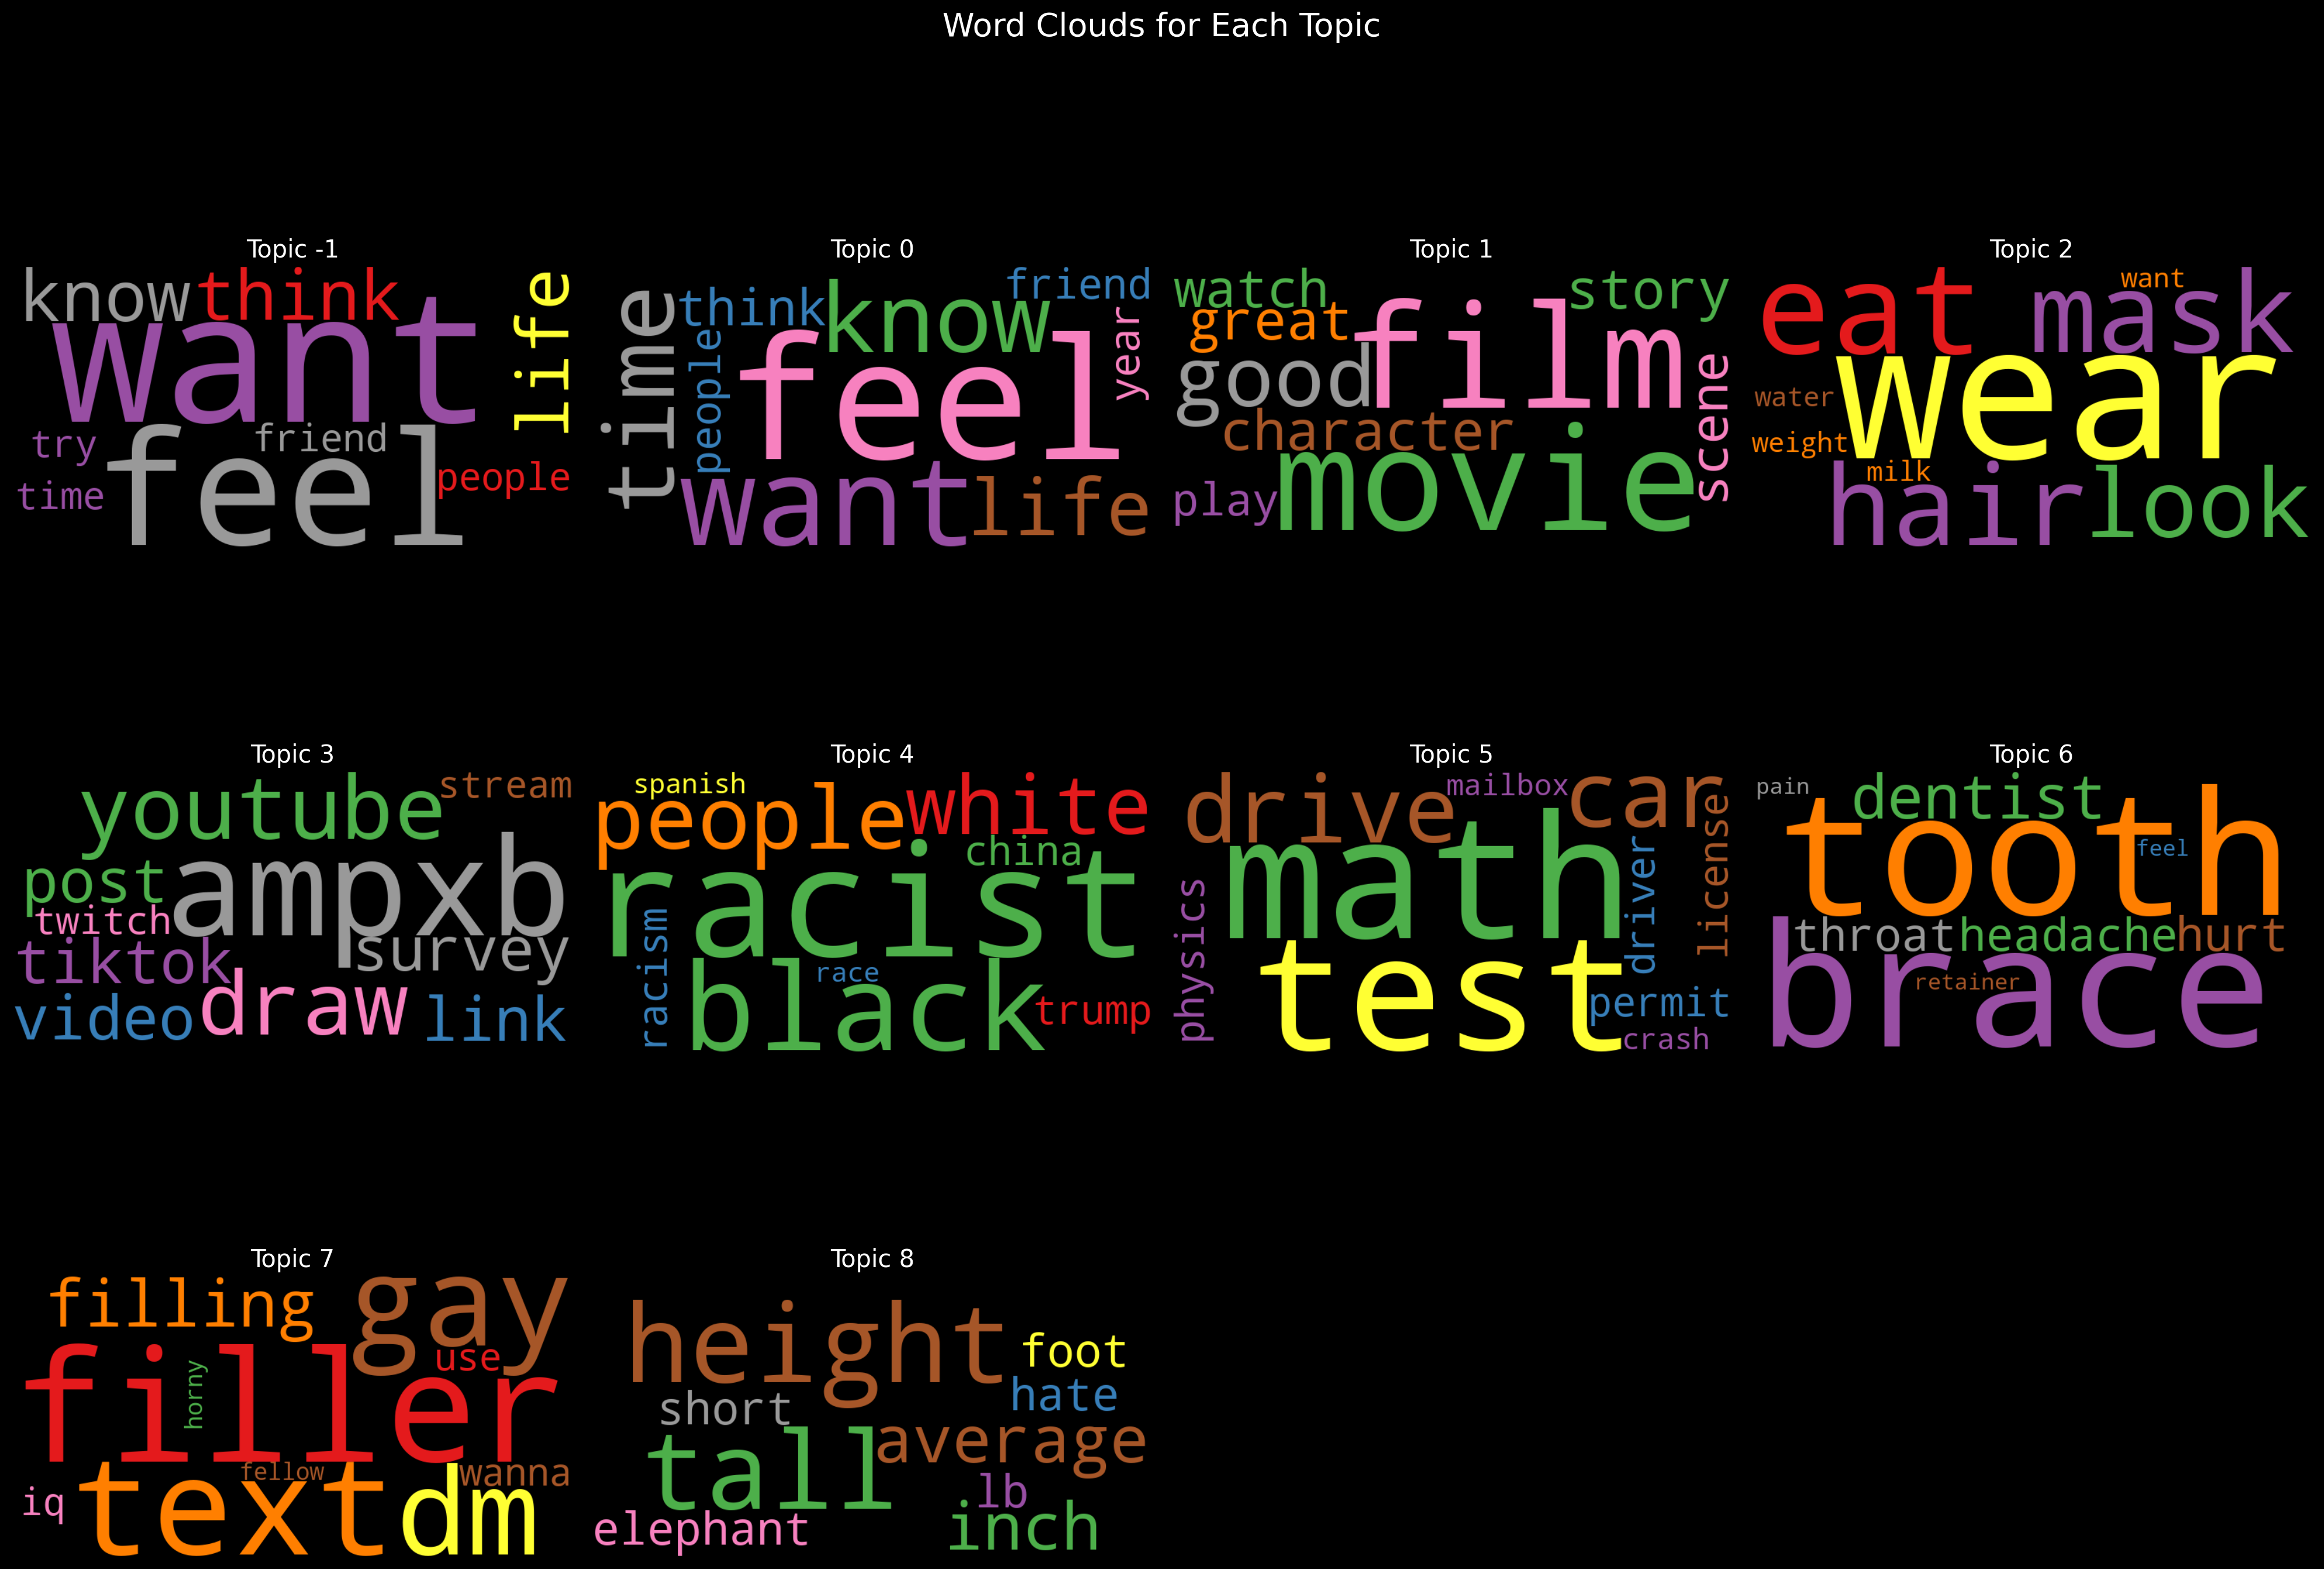

In [41]:
def create_wordcloud(words):
    text = ' '.join(words)
    wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Set1').generate(text)
    return wordcloud

fig, axes = plt.subplots(3, 4, figsize=(20, 15), facecolor='black')
fig.suptitle('Word Clouds for Each Topic', fontsize=20, color='white')

for index, row in topics_rep.iterrows():
    ax = axes[index // 4, index % 4]
    wordcloud = create_wordcloud(row['Representation'])
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Topic {row["Topic"]}', fontsize=15, color='white')
    ax.axis('off')

if len(topics_rep) % 4 != 0:
    for j in range(len(topics_rep) % 4, 4):
        fig.delaxes(axes[len(topics_rep) // 4, j])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [42]:
# Representative Documents
all_representative_docs = model.get_representative_docs()

doc_data = []
for topic_id, representative_docs in all_representative_docs.items():
    for doc in representative_docs:
        doc_data.append({"Topic": topic_id, "Document": doc})

rep_df = pd.DataFrame(doc_data)


In [43]:
rep_df

,Topic,Document
0,-1,want live birthday week think feel try past ye...
1,-1,delete later want somethingsome week ago month...
2,-1,grieve heap regret happy time yeari miss mum a...
3,0,feel like thisi know post like know long post ...
4,0,ramble honestyi feel like feel control feeling...
5,0,thought feeling day wall detailed text inbound...
6,1,write follow statement imdb message board user...
7,1,film remind nd street star bebe daniels ruby k...
8,1,watch friend try father ask d watch want old f...
9,2,alert karen encounter know guy probably care s...


In [44]:
# Labeling the texts by dominant topics
document_topics = []
for doc, topic in zip(docs, topics):
    document_topics.append(topic)

r_data = {"Document": docs, "Topic": document_topics}

r_df = pd.DataFrame(r_data)

In [45]:
r_df['Topic'].value_counts()

Topic
-1    13512
 0     8022
 1     2928
 2      537
 3      397
 4      122
 5      112
 6       58
 7       26
 8       25
Name: count, dtype: int64

In [46]:
r_df.head()

,Document,Topic
0,dear american teen question dutch person hear ...,-1
1,look forward lifei reason feel like day want hang,-1
2,music recommendation look expand playlist usua...,1
3,try feel betterthe reason alive know mum devas...,-1
4,worry year old girl subject domestic physicalm...,0


In [47]:
# Combining topic weights, texts and dominant topics together
topic_weights_df = pd.DataFrame(probabilities, columns=[f"Topic_{i}" for i in range(len(probabilities[0]))])

result_df = pd.concat([r_df, topic_weights_df], axis=1)

print(result_df)

                                                Document  Topic   Topic_0  \
0      dear american teen question dutch person hear ...     -1  0.494582   
1      look forward lifei reason feel like day want hang     -1  0.326281   
2      music recommendation look expand playlist usua...      1  0.337275   
3      try feel betterthe reason alive know mum devas...     -1  0.157648   
4      worry year old girl subject domestic physicalm...      0  0.842492   
...                                                  ...    ...       ...   
25734  post everyday people stop care religion matter...     -1  0.049227   
25735  okay definetly need hear guy opinion pretty lo...     -1  0.489335   
25736  dog think ill kill myselfthe thing hold yup ap...      0  0.745756   
25737  point princess bridei think like wesley pb lif...     -1  0.559331   
25738  nude person know snapchat ok chick know add sn...      0  1.000000   

             Topic_1        Topic_2        Topic_3        Topic_4  \
0     

In [48]:
# Adding "label" column to the data frame
result_df = pd.concat([result_df, df['label']], axis=1)

In [49]:
result_df

,Document,Topic,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,label
0,dear american teen question dutch person hear ...,-1,0.494582,1.054748e-02,3.438628e-02,5.561907e-02,2.805413e-02,6.241677e-02,7.060651e-03,3.190941e-03,3.851354e-03,0
1,look forward lifei reason feel like day want hang,-1,0.326281,4.223896e-03,2.023823e-02,1.973049e-02,1.033228e-02,8.144322e-03,8.802463e-03,1.578125e-03,2.176777e-03,1
2,music recommendation look expand playlist usua...,1,0.337275,4.431449e-01,5.295153e-02,1.123446e-01,1.987353e-02,1.365607e-02,7.649869e-03,5.795110e-03,7.309610e-03,0
3,try feel betterthe reason alive know mum devas...,-1,0.157648,1.727563e-03,6.850160e-03,8.476787e-03,4.415983e-03,3.843573e-03,2.758727e-03,6.355399e-04,8.062296e-04,1
4,worry year old girl subject domestic physicalm...,0,0.842492,1.018636e-02,3.777714e-02,4.620635e-02,2.538023e-02,1.945877e-02,1.062609e-02,3.583698e-03,4.288958e-03,1
...,...,...,...,...,...,...,...,...,...,...,...,...
25734,post everyday people stop care religion matter...,-1,0.049227,8.003567e-04,3.870985e-03,4.131189e-03,3.623792e-03,1.652989e-03,9.086189e-04,3.102521e-04,4.327462e-04,0
25735,okay definetly need hear guy opinion pretty lo...,-1,0.489335,8.292888e-03,3.371206e-02,5.182258e-02,2.313430e-02,1.261836e-02,6.074759e-03,4.178284e-03,4.478034e-03,0
25736,dog think ill kill myselfthe thing hold yup ap...,0,0.745756,1.615461e-02,8.520678e-02,6.552102e-02,3.464942e-02,2.590548e-02,1.569930e-02,4.404790e-03,6.702757e-03,1
25737,point princess bridei think like wesley pb lif...,-1,0.559331,7.959894e-03,3.400047e-02,3.882259e-02,2.527599e-02,1.991764e-02,1.015179e-02,2.749589e-03,3.896391e-03,1


In [50]:
# Barchart Visualization of topics 
model.visualize_barchart(top_n_topics=10)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': '#D55E00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.02571978980455724, 0.03012047401281137, 0.03227911192765021,
                    0.032297430631214916, 0.033325968605642096],
              'xaxis': 'x',
              'y': [time  , know  , want  , feel  , like  ],
              'yaxis': 'y'},
             {'marker': {'color': '#0072B2'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.02163341913735572, 0.024569121470615997,
                    0.02565570416372273, 0.060144326623382614, 0.06470546770827817],
              'xaxis': 'x2',
              'y': [story  , character  , good  , movie  , film  ],
              'yaxis': 'y2'},
             {'marker': {'color': '#CC79A7'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.039517786467944835, 0.04196427453394063,
                    0.043480589454234525, 0.04740872172562956, 0.06402846806798002],
              'xaxis': 'x3',
              'y': [hair  , like  , mask  , eat  , wear  ],
              'yaxis': 'y3'},
             {'marker': {'color': '#E69F00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.05128579611476272, 0.051562994241130596,
                    0.05985784298238669, 0.06040178575696723, 0.07109873730666708],
              'xaxis': 'x4',
              'y': [tiktok  , survey  , draw  , youtube  , ampxb  ],
              'yaxis': 'y4'},
             {'marker': {'color': '#56B4E9'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.04610392792086401, 0.05227755343258721,
                    0.060821759101674616, 0.06357717211309824, 0.06438464582099392],
              'xaxis': 'x5',
              'y': [trump  , white  , people  , black  , racist  ],
              'yaxis': 'y5'},
             {'marker': {'color': '#009E73'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.07040817626695295, 0.07291732270222694, 0.0808664527526118,
                    0.09990979436044373, 0.16203112041237872],
              'xaxis': 'x6',
              'y': [permit  , car  , drive  , test  , math  ],
              'yaxis': 'y6'},
             {'marker': {'color': '#F0E442'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.06625762956904808, 0.07223318767147477, 0.08762652150802597,
                    0.0973767179174502, 0.1989254369893447],
              'xaxis': 'x7',
              'y': [headache  , hurt  , dentist  , brace  , tooth  ],
              'yaxis': 'y7'},
             {'marker': {'color': '#D55E00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.05527876965240167, 0.05552225880808525, 0.08109444800027851,
                    0.15309481411875742, 1.626453920685337],
              'xaxis': 'x8',
              'y': [filling  , dm  , gay  , text  , filler  ],
              'yaxis': 'y8'},
             {'marker': {'color': '#0072B2'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.12066467749469043, 0.14239375729711343, 0.15368927895717588,
                    0.22756202464656353, 0.4214796703536487],
              'xaxis': 'x9',
              'y': [elephant  , inch  , average  , height  , tall  ],
              'yaxis': 'y9'}],
    'layout': {'annotations': [{'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 0',
                                'x': 0.0875,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                               {'font': {'size': 16},
                                'showarrow': False,
                 

In [51]:
# Save topic_labeled df to csv
r_df.to_csv("topic_labeled.csv")

In [52]:
r_df.head()

,Document,Topic
0,dear american teen question dutch person hear ...,-1
1,look forward lifei reason feel like day want hang,-1
2,music recommendation look expand playlist usua...,1
3,try feel betterthe reason alive know mum devas...,-1
4,worry year old girl subject domestic physicalm...,0


In [53]:
# Excluding Topic -1 values, filtering the data frame. 
filtered_df = result_df[result_df['Topic'] != -1]

print(filtered_df)


                                                Document  Topic   Topic_0  \
2      music recommendation look expand playlist usua...      1  0.337275   
4      worry year old girl subject domestic physicalm...      0  0.842492   
5      hey rredflag sure right place post currently s...      3  0.397985   
8      feel good set dateim kill friday nice finally ...      0  0.765023   
10     excercise motivate ngl wait shape know overnig...      0  0.626709   
...                                                  ...    ...       ...   
25730  wanna dieim shitty feel shitty time constantly...      0  0.497411   
25731  sleep stay awake night decide stay day fix sle...      0  0.871086   
25732  school guess coop goat farm quad today day wee...      0  0.510979   
25736  dog think ill kill myselfthe thing hold yup ap...      0  0.745756   
25738  nude person know snapchat ok chick know add sn...      0  1.000000   

             Topic_1        Topic_2        Topic_3        Topic_4  \
2     

In [54]:
# Save excluded df to csv
filtered_df.to_csv('topic_labeled_excluded.csv')

In [55]:
filtered_df

,Document,Topic,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,label
2,music recommendation look expand playlist usua...,1,0.337275,4.431449e-01,5.295153e-02,1.123446e-01,1.987353e-02,1.365607e-02,7.649869e-03,5.795110e-03,7.309610e-03,0
4,worry year old girl subject domestic physicalm...,0,0.842492,1.018636e-02,3.777714e-02,4.620635e-02,2.538023e-02,1.945877e-02,1.062609e-02,3.583698e-03,4.288958e-03,1
5,hey rredflag sure right place post currently s...,3,0.397985,1.589826e-02,4.393320e-02,4.177635e-01,3.437728e-02,1.971501e-02,6.753074e-03,4.935981e-03,5.368712e-03,1
8,feel good set dateim kill friday nice finally ...,0,0.765023,1.180516e-02,5.419640e-02,5.681336e-02,2.733645e-02,2.458437e-02,1.462141e-02,4.420595e-03,5.603925e-03,1
10,excercise motivate ngl wait shape know overnig...,0,0.626709,8.185427e-03,3.130071e-02,3.942897e-02,1.972556e-02,2.224843e-02,1.072053e-02,2.881777e-03,3.567880e-03,0
...,...,...,...,...,...,...,...,...,...,...,...,...
25730,wanna dieim shitty feel shitty time constantly...,0,0.497411,7.391939e-03,3.716719e-02,3.654740e-02,2.782885e-02,1.412955e-02,9.040309e-03,2.748562e-03,4.154570e-03,1
25731,sleep stay awake night decide stay day fix sle...,0,0.871086,7.859468e-03,3.763927e-02,3.282597e-02,1.467641e-02,1.348644e-02,1.609456e-02,2.850501e-03,3.480904e-03,0
25732,school guess coop goat farm quad today day wee...,0,0.510979,1.195206e-02,4.273385e-02,6.836204e-02,4.581315e-02,4.156932e-02,8.020173e-03,3.715045e-03,4.521359e-03,0
25736,dog think ill kill myselfthe thing hold yup ap...,0,0.745756,1.615461e-02,8.520678e-02,6.552102e-02,3.464942e-02,2.590548e-02,1.569930e-02,4.404790e-03,6.702757e-03,1


In [65]:
# Setting threshold value for topics, excluding <100 count topics. (topic 6,7,8)

threshold_df = filtered_df[~filtered_df['Topic'].isin([6, 7, 8])]
threshold_df = threshold_df.drop(columns=['Topic_6', 'Topic_7', 'Topic_8'])


In [66]:
threshold_df

,Document,Topic,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,label
2,music recommendation look expand playlist usua...,1,0.337275,4.431449e-01,5.295153e-02,1.123446e-01,1.987353e-02,1.365607e-02,0
4,worry year old girl subject domestic physicalm...,0,0.842492,1.018636e-02,3.777714e-02,4.620635e-02,2.538023e-02,1.945877e-02,1
5,hey rredflag sure right place post currently s...,3,0.397985,1.589826e-02,4.393320e-02,4.177635e-01,3.437728e-02,1.971501e-02,1
8,feel good set dateim kill friday nice finally ...,0,0.765023,1.180516e-02,5.419640e-02,5.681336e-02,2.733645e-02,2.458437e-02,1
10,excercise motivate ngl wait shape know overnig...,0,0.626709,8.185427e-03,3.130071e-02,3.942897e-02,1.972556e-02,2.224843e-02,0
...,...,...,...,...,...,...,...,...,...
25730,wanna dieim shitty feel shitty time constantly...,0,0.497411,7.391939e-03,3.716719e-02,3.654740e-02,2.782885e-02,1.412955e-02,1
25731,sleep stay awake night decide stay day fix sle...,0,0.871086,7.859468e-03,3.763927e-02,3.282597e-02,1.467641e-02,1.348644e-02,0
25732,school guess coop goat farm quad today day wee...,0,0.510979,1.195206e-02,4.273385e-02,6.836204e-02,4.581315e-02,4.156932e-02,0
25736,dog think ill kill myselfthe thing hold yup ap...,0,0.745756,1.615461e-02,8.520678e-02,6.552102e-02,3.464942e-02,2.590548e-02,1


In [67]:
# Normalizing remaining topics weights, (sum of topic weights = 1)
cols_to_normalize = ['Topic_0', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5']
threshold_df[cols_to_normalize] = threshold_df[cols_to_normalize].div(threshold_df[cols_to_normalize].sum(axis=1), axis=0)


In [68]:
threshold_df

,Document,Topic,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,label
2,music recommendation look expand playlist usua...,1,0.344423,4.525371e-01,5.407381e-02,1.147256e-01,2.029474e-02,1.394550e-02,0
4,worry year old girl subject domestic physicalm...,0,0.858371,1.037835e-02,3.848915e-02,4.707722e-02,2.585858e-02,1.982552e-02,1
5,hey rredflag sure right place post currently s...,3,0.428091,1.710094e-02,4.725668e-02,4.493666e-01,3.697787e-02,2.120642e-02,1
8,feel good set dateim kill friday nice finally ...,0,0.814063,1.256190e-02,5.767055e-02,6.045526e-02,2.908880e-02,2.616030e-02,1
10,excercise motivate ngl wait shape know overnig...,0,0.838297,1.094896e-02,4.186834e-02,5.274083e-02,2.638524e-02,2.975986e-02,0
...,...,...,...,...,...,...,...,...,...
25730,wanna dieim shitty feel shitty time constantly...,0,0.801660,1.191334e-02,5.990112e-02,5.890222e-02,4.485082e-02,2.277212e-02,1
25731,sleep stay awake night decide stay day fix sle...,0,0.891070,8.039767e-03,3.850273e-02,3.357901e-02,1.501309e-02,1.379583e-02,0
25732,school guess coop goat farm quad today day wee...,0,0.708307,1.656765e-02,5.923660e-02,9.476175e-02,6.350504e-02,5.762236e-02,0
25736,dog think ill kill myselfthe thing hold yup ap...,0,0.766298,1.659960e-02,8.755383e-02,6.732582e-02,3.560385e-02,2.661905e-02,1


In [69]:
# Saving the final dataframe
threshold_df.to_csv("threshold_df.csv")